# Building Metapaths by OSMNx and City2Graph

This notebook demonstrates how to construct a **metapath** on a heterogeneous graph using `City2Graph`.

A **metapath** defines a composite relation between nodes in **a heterogeneous graph**, widely used in **Graph Neural Networks (GNN)**. 

For example, `Amenity -> Segment -> Segment -> Amenity` connects two amenities if they are accessible via a short walk (two street segments).

We will:
1.  **Fetch Data**: Get the street network and amenities for Soho, London using `osmnx` (OpenStreetMap).
2.  **Construct Graph**: Create a dual graph of the streets using `NetworkX` concepts.
3.  **Bridge Nodes**: Connect amenities to the street network using spatial joins with `GeoPandas`.
4.  **Add Metapaths**: Materialize the `Amenity-Segment-Segment-Amenity` relationship to densify the graph.
5.  **Visualization**: Visualize the metapaths with an animation.
6.  **Add Metapaths by Weight**: Connect amenities based on travel distance for weighted graph analysis.

In [1]:
import geopandas as gpd
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation
import city2graph as c2g

## 0. What is a Metapath in Heterogeneous Graphs?

A **metapath** is a sequence of relations between node types in a heterogeneous graph. It describes a composite relationship between two nodes and is fundamental for capturing semantic information in **Graph Neural Networks (GNN)**.

For example, in our city graph:
1.  **Amenity** (e.g., a Cafe) is connected to a **Street Segment** (is_nearby).
2.  **Street Segment** is connected to another **Street Segment** (connects_to).
3.  **Street Segment** is connected to another **Amenity** (is_nearby).

This forms the metapath `Amenity -> Segment -> Segment -> Amenity`, representing that two amenities are within a short walking distance (2 segments) of each other. This structure allows GNNs to learn embeddings based on connectivity patterns.

![Illustration of an Amenity-Segment-Segment-Amenity metapath in a city street network](../_static/metapath_in_city.png)

## 1. Fetch Data from OpenStreetMap
We download the street network and amenities (cafes, pubs, etc.) for Soho, London. This time we use **OpenStreetMap** via `OSMnx`. While `City2Graph` supports a variety of data sources, it has direct compatibility to `OSMnx` objects (e.g. `c2g.nx_to_gdf(), c2g.dual_graph(), c2g.nx_to_pyg()` and many others), making it easy to integrate with existing geospatial workflows.

In [2]:
# Download and project the street network to British National Grid (EPSG:27700) for metric distances
# Data should be obtained from Only in Soho, London
G = ox.graph_from_place(
    "Soho, London",
    network_type="all",
)

street_primary_nodes, street_primary_edges = c2g.nx_to_gdf(G)
street_primary_nodes = street_primary_nodes.to_crs(epsg=27700)
street_primary_edges = street_primary_edges.to_crs(epsg=27700)

amenity_tags = ["cafe", "restaurant", "pub", "bar", "museum", "theatre", "cinema"]
amenity_candidates = ox.features_from_place(
    "Soho, London",
    tags={"amenity": amenity_tags},
).to_crs(epsg=27700)

For the analysis, we clean up the amenities.

In [3]:
# Collapse complex Amenity geometries to points within the projected CRS
amenities = (
    amenity_candidates[["name", "amenity", "geometry"]]
    .copy()
    .explode(index_parts=False)
    .dropna(subset=["geometry"])
)
non_point_mask = ~amenities.geometry.geom_type.isin(["Point"])
amenities.loc[non_point_mask, "geometry"] = amenities.loc[non_point_mask, "geometry"].centroid
amenities = amenities.set_geometry("geometry")
amenities["name"] = amenities["name"].fillna(amenities["amenity"].str.title())
amenities = amenities[~amenities.geometry.is_empty]
amenities = amenities.drop_duplicates(subset="geometry").reset_index(drop=True)

In [4]:
# Display street network data
print("Street Primary Nodes:")
display(street_primary_nodes.head(3))
print("\nStreet Primary Edges:")
display(street_primary_edges.head(3))
print("\nAmenities:")
display(amenities.head(3))

Street Primary Nodes:


,y,x,street_count,geometry,highway,railway
107324,51.515651,-0.132443,4,POINT (529683.159 181289.359),NaN,NaN
107326,51.515148,-0.132727,4,POINT (529664.875 181232.921),NaN,NaN
107328,51.514837,-0.132323,3,POINT (529693.803 181199.041),NaN,NaN



Street Primary Edges:


osmid      highway maxspeed         name  oneway  \
107324 12437701118 0   59207650  residential   20 mph  Soho Street   False   
       11310505522 0  395757466      footway      NaN          NaN   False   
       1694551556  0    4082521  residential   20 mph  Soho Square    True   

                     reversed     length  \
107324 12437701118 0    False   8.366709   
       11310505522 0    False   6.567612   
       1694551556  0    False  74.927392   

                                                               geometry lanes  \
107324 12437701118 0  LINESTRING (529683.159 181289.359, 529679.695 ...   NaN   
       11310505522 0  LINESTRING (529683.159 181289.359, 529684.78 1...   NaN   
       1694551556  0  LINESTRING (529683.159 181289.359, 529706.44 1...   NaN   

                     access width tunnel service  
107324 12437701118 0    NaN   NaN    NaN     NaN  
       11310505522 0    NaN   NaN    NaN     NaN  
       1694551556  0    NaN   NaN    NaN     NaN


Amenities:


,name,amenity,geometry
0,Curzon Soho,cinema,POINT (529818.965 180959.788)
1,Pastaio,restaurant,POINT (529233.765 180972.225)
2,Yauatcha,restaurant,POINT (529498.558 181064.047)


## 2. Construct Dual Graph for Street Networks
We convert the primary street graph (intersections as nodes) to a **dual graph** (streets as nodes). In urban analytics, dual graphs are often better for analyzing connectivity and flow between streets, as edges represent the connections between street segments rather than physical intersections.

In [5]:
street_dual_nodes, street_dual_edges = c2g.dual_graph((street_primary_nodes, street_primary_edges))

street_dual_nodes.geometry = street_dual_nodes.geometry.centroid

In [6]:
# Display dual graph data
print("Street Dual Nodes (Segments):")
display(street_dual_nodes.head(3))
print("\nStreet Dual Edges (Connections):")
display(street_dual_edges.head(3))

Street Dual Nodes (Segments):


osmid      highway maxspeed         name  oneway  \
107324 12437701118 0   59207650  residential   20 mph  Soho Street   False   
       11310505522 0  395757466      footway      NaN          NaN   False   
       1694551556  0    4082521  residential   20 mph  Soho Square    True   

                     reversed     length                       geometry lanes  \
107324 12437701118 0    False   8.366709  POINT (529681.427 181293.171)   NaN   
       11310505522 0    False   6.567612   POINT (529683.97 181286.175)   NaN   
       1694551556  0    False  74.927392  POINT (529714.059 181289.894)   NaN   

                     access width tunnel service  
107324 12437701118 0    NaN   NaN    NaN     NaN  
       11310505522 0    NaN   NaN    NaN     NaN  
       1694551556  0    NaN   NaN    NaN     NaN


Street Dual Edges (Connections):


geometry
from_edge_id                  to_edge_id                                                                      
(10693880886, 10693880887, 0) (10693880886, 11815774945, 0)  LINESTRING (529790.105 181134.445, 529782.217 ...
                              (10693880886, 12437444593, 0)  LINESTRING (529790.105 181134.445, 529809.944 ...
                              (10693880887, 10693880886, 0)  LINESTRING (529790.105 181134.445, 529790.105 ...

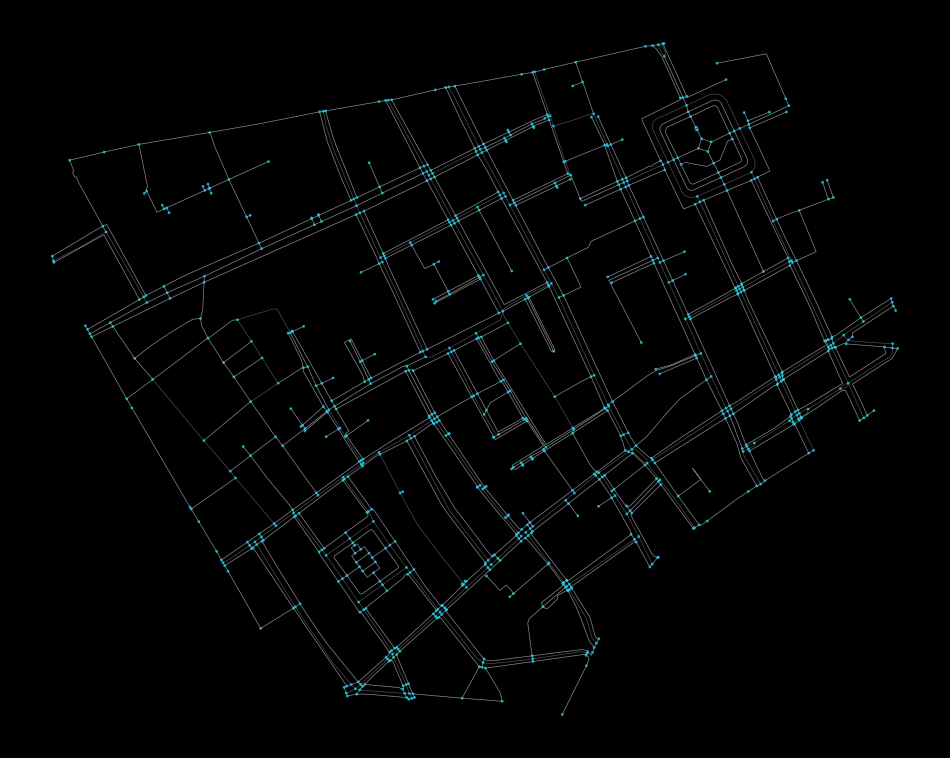

In [7]:
c2g.plot_graph(nodes=street_primary_nodes, 
               edges=street_primary_edges)

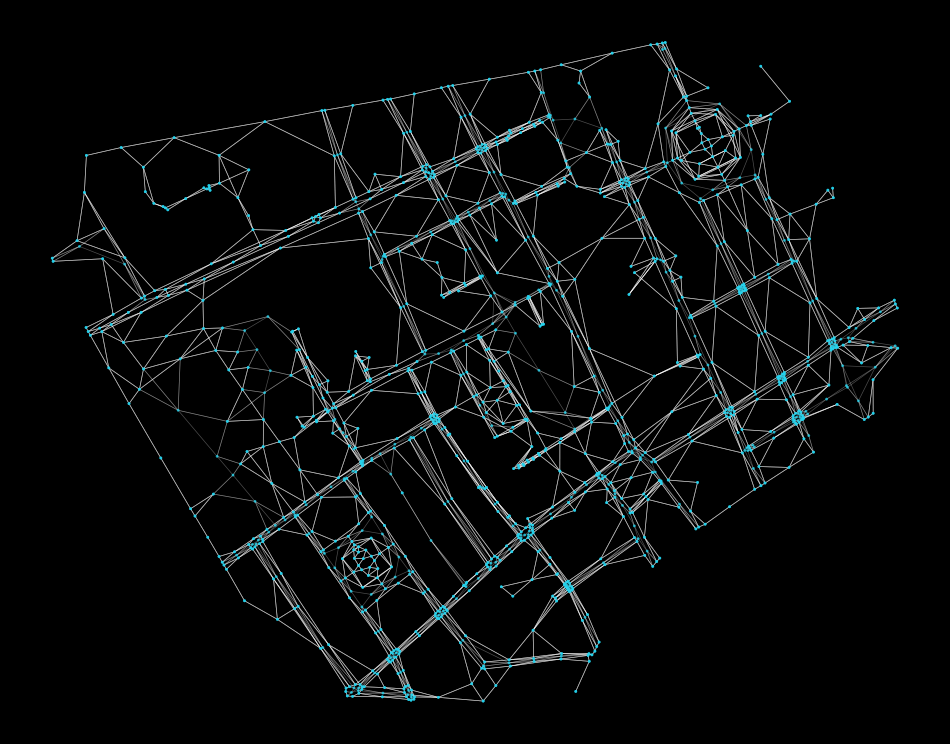

In [8]:
c2g.plot_graph(nodes=street_dual_nodes, 
               edges=street_dual_edges)

## 3. Bridge Nodes (Connect Amenities)
We attach amenities to their nearest street segment (dual node) using `bridge_nodes`. This creates a heterogeneous graph with two node types: `amenity` and `segment`.

In [9]:
nodes_dict = {
    "amenity": amenities,
    "segment": street_dual_nodes
}

edges_dict = {
    ("segment", "connects_to", "segment"): street_dual_edges
}

# Connect amenities to segments
# bridge_nodes returns the node dictionary and a new dictionary of proximity edges
_, bridged_edges = c2g.bridge_nodes(
    nodes_dict=nodes_dict,
    proximity_method="knn",
    source_node_types=["amenity"],
    target_node_types=["segment"],
    k=1  # Connect to the single nearest segment
)

# Add the street network edges to the edges dictionary
edges_dict.update(bridged_edges)

In [10]:
bridged_edges.keys()

dict_keys([('amenity', 'is_nearby', 'segment')])

In [11]:
bridged_edges[('amenity', 'is_nearby', 'segment')].head(3)

,,weight,geometry
source,target,,
0,"(12437452142, 12437452112, 0)",17.075425,"LINESTRING (529818.965 180959.788, 529802.062 ..."
1,"(25473373, 21665930, 0)",7.276304,"LINESTRING (529233.765 180972.225, 529227.711 ..."
2,"(11310267309, 11310267304, 0)",6.238117,"LINESTRING (529498.558 181064.047, 529492.905 ..."


## 4. Add Metapaths: Materializing Composite Relations
We now define and add the metapath `Amenity -> Segment -> Segment -> Segment -> Amenity`.

The function `add_metapaths` takes a sequence of edge types (triplets) and computes the composite edges. It returns the updated graph with new metapath edges. This "materialization" of metapaths explicitly adds edges between amenities that are topologically close, which can significantly improve the performance of graph learning algorithms.

In [12]:
# Define sequence for 1 to 10 street hops
sequence = []
hops = 3
# Start: Amenity -> Segment
sequence = [("amenity", "is_nearby", "segment")]

# Middle: Segment -> Segment (i times)
for _ in range(hops):
    sequence.append(("segment", "connects_to", "segment"))

# End: Segment -> Amenity
sequence.append(("segment", "is_nearby", "amenity"))

print(sequence)

[('amenity', 'is_nearby', 'segment'), ('segment', 'connects_to', 'segment'), ('segment', 'connects_to', 'segment'), ('segment', 'connects_to', 'segment'), ('segment', 'is_nearby', 'amenity')]


In [13]:
# Materialize the metapath edges
result_nodes, result_edges = c2g.add_metapaths(nodes=nodes_dict,
                                               edges=edges_dict,
                                               sequence=sequence,
                                               new_relation_name="is_3_hop_nearby")

In [14]:
for key in result_nodes.keys():
    print(key)

amenity
segment


In [15]:
for key in result_edges.keys():
    print(key)

('segment', 'connects_to', 'segment')
('amenity', 'is_nearby', 'segment')
('amenity', 'is_3_hop_nearby', 'amenity')


In [22]:
print(result_edges[('amenity', 'is_3_hop_nearby', 'amenity')].head(3))

               weight                                           geometry
source source                                                           
1      296          4  LINESTRING (529233.765 180972.225, 529148.82 1...
       86           2  LINESTRING (529233.765 180972.225, 529252.794 ...
       129          2  LINESTRING (529233.765 180972.225, 529251.114 ...


## 5. Visualization of Metapath Connections
Let's visualize the connections. We'll pick a random amenity and show which other amenities are reachable via this metapath. Visualizing these connections helps verify the graph structure and understand the reachability of amenities within the street network.

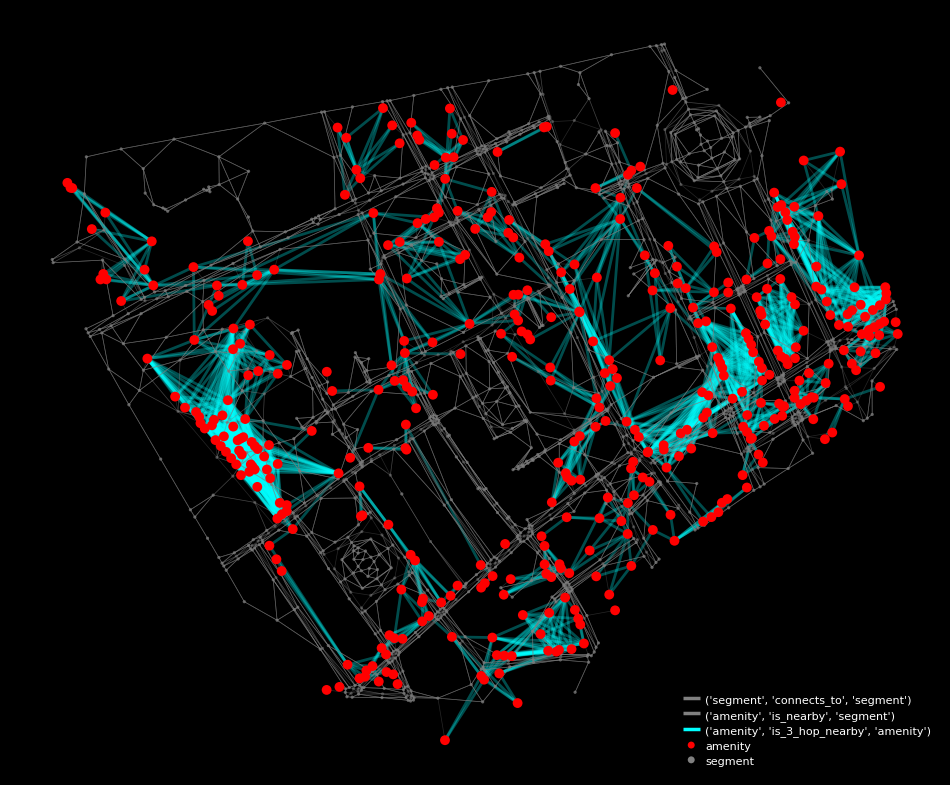

In [17]:
# Visualize the graph with metapaths
# We want to highlight the metapath connections
# Define colors and z-orders for clarity
node_color = {
    "amenity": "red",
    "segment": "gray"
}
node_zorder = {
    "amenity": 3,
    "segment": 1
}
node_alpha = {
    "amenity": 1.0,
    "segment": 0.5
}
markersize = {
    "amenity": 50,
    "segment": 5
}

edge_color = {
    ("segment", "connects_to", "segment"): "gray",
    ("amenity", "is_nearby", "segment"): "gray",
    ("amenity", "is_3_hop_nearby", "amenity"): "cyan",
}
edge_zorder = {
    ("segment", "connects_to", "segment"): 3,
    ("amenity", "is_nearby", "segment"): 1
}
edge_linewidth = {
    ("segment", "connects_to", "segment"): 0.5,
    ("amenity", "is_nearby", "segment"): 0.5,
    ("amenity", "is_3_hop_nearby", "amenity"): 2.0,
}

# Plot
c2g.plot_graph(
    nodes=result_nodes,
    edges=result_edges,
    node_color=node_color,
    node_zorder=node_zorder,
    node_alpha=node_alpha,
    markersize=markersize,
    edge_color=edge_color,
    edge_zorder=edge_zorder,
    edge_linewidth=edge_linewidth,
    bgcolor="black",
    legend_position="lower right",
    subplots=False
)

## 6. Add Metapaths by Weight: Distance-Based Connectivity
Alternatively, we can connect amenities based on a weight threshold (e.g., distance or time) using `add_metapaths_by_weight`. This uses Dijkstra's algorithm to find all reachable nodes within a specified limit and edge types.

In [18]:
nodes_dict = {
    "amenity": amenities,
    "intersection": street_primary_nodes
}

edges_dict = {
    ("intersection", "connects_to", "intersection"): street_primary_edges
}

_, bridged_edges = c2g.bridge_nodes(
    nodes_dict=nodes_dict,
    proximity_method="knn",
    source_node_types=["amenity"],
    target_node_types=["intersection"],
    k=1
)

edges_dict.update(bridged_edges)

# set travel time in seconds assuming average walking speed of 4 km/h
walking_speed_kmh = 4
walking_speed_mps = walking_speed_kmh * 1000 / 3600  # convert km/h to m/s

# Add travel time attribute to edges
for edge_type, edge_gdf in edges_dict.items():
    edges_dict[edge_type]["travel_time_sec"] = edge_gdf.length / walking_speed_mps

In this case, endpoint is specified as `amenity`. Between each amenity across the edge types, metapaths are calculated by the threshold `60` of accumulative weight by `travel_time_sec`.

In [19]:
# Connect amenities within 500 meters walking distance
weight_nodes, weight_edges = c2g.add_metapaths_by_weight(
    nodes=nodes_dict,
    edges=edges_dict,
    weight="travel_time_sec",
    threshold=60,
    new_relation_name="is_within_1_min",
    endpoint_type="amenity",
    directed=False
)

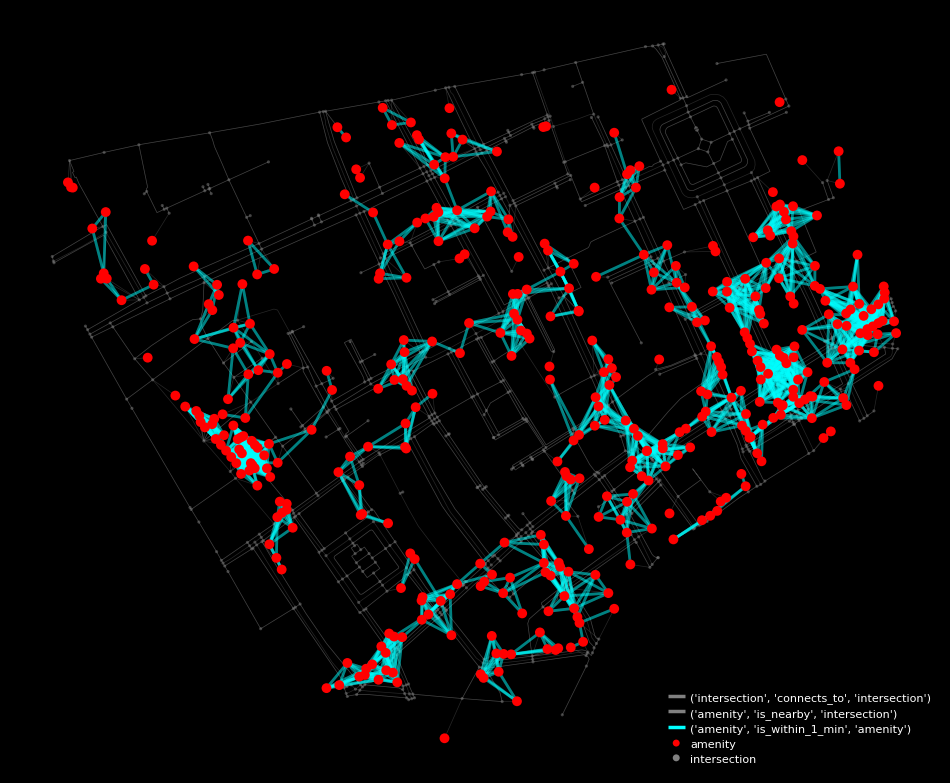

In [20]:
# Visualize the weighted metapaths
node_color = {
    "amenity": "red",
    "intersection": "gray"
}
node_zorder = {
    "amenity": 3,
    "intersection": 1
}
node_alpha = {
    "amenity": 1.0,
    "intersection": 0.5
}
markersize = {
    "amenity": 50,
    "intersection": 5
}

edge_color = {
    ("intersection", "connects_to", "intersection"): "gray",
    ("amenity", "is_nearby", "intersection"): "gray",
    ("amenity", "is_within_1_min", "amenity"): "cyan"
}
edge_zorder = {
    ("intersection", "connects_to", "intersection"): 1,
    ("amenity", "is_nearby", "intersection"): 1,
    ("amenity", "is_within_1_min", "amenity"): 2
}
edge_linewidth = {
    ("intersection", "connects_to", "intersection"): 0.5,
    ("amenity", "is_nearby", "intersection"): 0.5,
    ("amenity", "is_within_1_min", "amenity"): 2.0
}

c2g.plot_graph(
    nodes=weight_nodes,
    edges=weight_edges,
    node_color=node_color,
    node_zorder=node_zorder,
    node_alpha=node_alpha,
    markersize=markersize,
    edge_color=edge_color,
    edge_zorder=edge_zorder,
    edge_linewidth=edge_linewidth,
    bgcolor="black",
    title="Metapaths by Weight (Travel Time < 1 min)",
    legend_position="lower right",
    subplots=False
)